In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
import datetime
import os
import matplotlib.style
from pandas.core.common import flatten
from functools import partial, reduce

In [13]:
plt.style.use('ggplot')

In [14]:
pairs_list = [
    'EURUSD/EURUSD_H4 - EURUSD_H4',
    'AUDUSD/AUDUSD_H4 - AUDUSD_H4',
    'GBPUSD/GBPUSD_H4 - GBPUSD_H4',
    'NZDUSD/NZDUSD_H4 - NZDUSD_H4',
    'USDCAD/USDCAD_H4 - USDCAD_H4',
    'USDCHF/USDCHF_H4 - USDCHF_H4',
    'USDJPY/USDJPY_H4 - USDJPY_H4',
    'XAUUSD/XAUUSD_H4 - XAUUSD_H4',
]

In [15]:
df ={}
for pair in range(len(pairs_list)) :
    df[pair] = pd.read_csv('../../Data_Forex/'+pairs_list[pair]+'.csv',index_col=0,parse_dates=True)

In [16]:
def Bollinger_bands(df, window, std_mult):
    df['rolling_mean'] = df['Close'].rolling(window).mean()
    df['rolling_std'] = df['Close'].rolling(window).std()
    df['upper_band'] = df['rolling_mean'] + (df['rolling_std'] * std_mult)
    df['lower_band'] = df['rolling_mean'] - (df['rolling_std'] * std_mult)
    return df

def SMA(df, fast, slow):
    df['sma_fast'] = df['Close'].rolling(fast).mean()
    df['sma_slow'] = df['Close'].rolling(slow).mean()
    return df

def ATR(df, n):
    df = df.copy()
    df['High-Low'] = abs(df['High'] - df['Low'])
    df['High-PrevClose'] = abs(df['High'] - df['Close'].shift(1))
    df['Low-PrevClose'] = abs(df['Low'] - df['Close'].shift(1))
    df['TR'] = df[['High-Low', 'High-PrevClose', 'Low-PrevClose']].max(axis = 1, skipna = False)
    df['ATR'] = df['TR'].rolling(n).mean()
    df = df.drop(['High-Low', 'High-PrevClose', 'Low-PrevClose'], axis = 1)
    return df

def CAGR(df, source_df,account_size):
    df = df.copy()
    n = len(source_df) / (252*24)
    return round((((df['cum_res'][-1] / account_size)**(1/n)) - 1) * 100, 1)

def sharpe_ratio(df):
    df = df.copy()
    returns = df['cum_res'].pct_change()
    volatility = returns.std() * np.sqrt(252)
    return round((returns.mean() - 0.02) / volatility, 2)

def max_drawdown(df):
    df = df.copy()
    cum_returns = (1 + df['cum_res']).cumprod()
    drawdown = 1 - df['cum_res'].div(df['cum_res'].cummax())
    return round(max(drawdown.expanding().max() * 100), 2)

In [17]:
#Strategy parameters
account_size = 1000
slippage = 2
size = 1
ATR_SL = 0.5

for pair in range(len(pairs_list)):
    df[pair]['ATR'] = ATR(df[pair], 20)['ATR']
    df[pair]['sma_fast'] = SMA(df[pair], 50, 200)['sma_fast']
    df[pair]['upper_band'] = Bollinger_bands(df[pair], 50, 3)['upper_band']
    if 'USDJPY/USDJPY_H4 - USDJPY_H4'  not in pairs_list[pair] and 'XAUUSD/XAUUSD_H4 - XAUUSD_H4'  not in pairs_list[pair] :
        df[pair]['spread'] = float(slippage) / float(10000)
        df[pair]['size'] = float(size) * float(10000)
        print('Pair: ', pairs_list[pair], 'a')
    else:
        df[pair]['spread'] = float(slippage) / float(100)
        df[pair]['size'] = float(size) * float(100)
        print('Pair: ', pairs_list[pair], 'b')

Pair:  EURUSD/EURUSD_H4 - EURUSD_H4 a
Pair:  AUDUSD/AUDUSD_H4 - AUDUSD_H4 a
Pair:  GBPUSD/GBPUSD_H4 - GBPUSD_H4 a
Pair:  NZDUSD/NZDUSD_H4 - NZDUSD_H4 a
Pair:  USDCAD/USDCAD_H4 - USDCAD_H4 a
Pair:  USDCHF/USDCHF_H4 - USDCHF_H4 a
Pair:  USDJPY/USDJPY_H4 - USDJPY_H4 b
Pair:  XAUUSD/XAUUSD_H4 - XAUUSD_H4 b


In [18]:
open_trade = {}
trade = {}
long_take_profit = {}
short_take_profit = {}
long_stop_loss = {}
short_stop_loss = {}
long_entry_price = {}
short_entry_price = {}

for pair in range(len(pairs_list)):
    open_trade[pair] = []
    trade[pair] = {}
    long_take_profit[pair] = []
    short_take_profit[pair] = []
    long_stop_loss[pair] = []
    short_stop_loss[pair] = []
    long_entry_price[pair] = []
    short_entry_price[pair] = []
    
    for i in range(50, len(df[pair])):
        #Buy
        if df[pair]['sma_fast'][i-1] > df[pair]['sma_slow'][i-1] and any (df[pair]['Close'][i-3: i-1].values) <= any (df[pair]['lower_band'][i-3: i-1].values)\
            and df[pair]['Close'][i] >= df[pair]['rolling_mean'][i] and len(open_trade[pair]) == 0:
            print(i, 'New Long trade at price:', round(df[pair]['Close'][i], 4), ' On day:', df[pair].index[i], 'Pair:', pairs_list[pair])
            trade[pair][i] = {'ID': i,
                             'date_of_trade': df[pair].index[i],
                             'entry_price': df[pair]['Close'][i],
                             'signal': 'Buy',
                             'result': 0, 
                             'TP': df[pair]['Close'][i] + df[pair]['ATR'][i] * 10 * ATR_SL,
                             'SL': df[pair]['Close'][i] - df[pair]['ATR'][i] * ATR_SL}
            open_trade[pair].append(i)
            long_take_profit[pair].append(trade[pair][i]['TP'])
            long_stop_loss[pair].append(trade[pair][i]['SL'])
            long_entry_price[pair].append(trade[pair][i]['entry_price'])
        
        #Sell
        if df[pair]['sma_fast'][i-1] < df[pair]['sma_slow'][i-1] and any (df[pair]['Close'][i-3: i-1].values) >= any (df[pair]['upper_band'][i-3: i-1].values)\
            and df[pair]['Close'][i] <= df[pair]['rolling_mean'][i] and len(open_trade[pair]) == 0:
            print(i, 'New Short trade at price:', round(df[pair]['Close'][i], 4), ' On day:', df[pair].index[i], 'Pair:', pairs_list[pair])
            trade[pair][i] = {'ID': i,
                             'date_of_trade': df[pair].index[i],
                             'entry_price': df[pair]['Close'][i],
                             'signal': 'Sell',
                             'result': 0, 
                             'TP': df[pair]['Close'][i] - df[pair]['ATR'][i] * 10 * ATR_SL,
                             'SL': df[pair]['Close'][i] + df[pair]['ATR'][i] * ATR_SL}
            open_trade[pair].append(i)
            short_take_profit[pair].append(trade[pair][i]['TP'])
            short_stop_loss[pair].append(trade[pair][i]['SL'])
            short_entry_price[pair].append(trade[pair][i]['entry_price'])
            
        #Exit trades---------------------------------------------------------------------------
        #Buy Trailing SL
        if any(y <= df[pair]['Close'][i] for y in long_entry_price[pair]):
            for j in open_trade[pair]:
                if trade[pair][j].get('result', {}) == 0 and trade[pair][j].get('signal', {}) == 'Buy':
                    #Move SL to BE
                    if df[pair]['Close'][i] >= trade[pair][j]['entry_price'] + (df[pair]['ATR'][i] * ATR_SL):
                        long_stop_loss[pair] = []
                        trade[pair][j].update({'SL' : trade[pair][j]['entry_price'] + df[pair]['spread'][i]})
                        print(j, 
                             'Moved SL to BE:', round(trade[pair][j]['SL'], 4),
                             'On day:', df[pair].index[i], '\n')
                        long_entry_price[pair] = []
                        long_stop_loss[pair].append(trade[pair][j]['SL'])
                    #Move SL to first ATR
                    if df[pair]['Close'][i] >= trade[pair][j]['entry_price'] + (df[pair]['ATR'][i] * 2 * ATR_SL):
                        long_stop_loss[pair] = []
                        trade[pair][j].update({'SL' : trade[pair][j]['entry_price'] + (df[pair]['ATR'][i] * ATR_SL)})
                        print(j, 
                             'Trailing SL to first ATR:', round(trade[pair][j]['SL'], 4),
                             'On day:', df[pair].index[i], '\n')
                        long_stop_loss[pair].append(trade[pair][j]['SL'])
        #Sell Trailing SL
        if any(y >= df[pair]['Close'][i] for y in short_entry_price[pair]):
            for j in open_trade[pair]:
                if trade[pair][j].get('result', {}) == 0 and trade[pair][j].get('signal', {}) == 'Sell':
                    #Move SL to BE
                    if df[pair]['Close'][i] <= trade[pair][j]['entry_price'] - (df[pair]['ATR'][i] * ATR_SL):
                        short_stop_loss[pair] = []
                        trade[pair][j].update({'SL' : trade[pair][j]['entry_price'] - df[pair]['spread'][i]})
                        print(j, 
                             'Moved SL to BE:', round(trade[pair][j]['SL'], 4),
                             'On day:', df[pair].index[i], '\n')
                        short_entry_price[pair] = []
                        short_stop_loss[pair].append(trade[pair][j]['SL'])
                    #Move SL to first ATR
                    if df[pair]['Close'][i] <= trade[pair][j]['entry_price'] - (df[pair]['ATR'][i] * 2 * ATR_SL):
                        short_stop_loss[pair] = []
                        trade[pair][j].update({'SL' : trade[pair][j]['entry_price'] - (df[pair]['ATR'][i] * ATR_SL)})
                        print(j, 
                             'Trailing SL to first ATR:', round(trade[pair][j]['SL'], 4),
                             'On day:', df[pair].index[i], '\n')
                        short_stop_loss[pair].append(trade[pair][j]['SL'])
                        
        #Buy profit
        if any(y <= df[pair]['Close'][i] for y in long_take_profit[pair]):
            for j in open_trade[pair]:
                if trade[pair][j].get('result', {}) == 0 and trade[pair][j].get('signal', {}) == 'Buy':
                    if df[pair]['Close'][i] >= trade[pair][j]['TP']:
                        trade[pair][j].update({'result' : (trade[pair][j]['TP'] - trade[pair][j]['entry_price'] - df[pair]['spread'][i]) * df[pair]['size'][i]})
                        print(j, 
                             'Long profit at price:', round(df[pair]['Close'][i], 4),
                             'On day:', df[pair].index[i],
                             'With profit:', round(trade[pair][j]['result'], 4), '\n')
                        open_trade[pair].remove(j)
                        long_take_profit[pair].remove(trade[pair][j]['TP'])
                        long_stop_loss[pair].remove(trade[pair][j]['SL'])
        #Buy loss
        if any(y >= df[pair]['Close'][i] for y in long_stop_loss[pair]):
            for j in open_trade[pair]:
                if trade[pair][j].get('result', {}) == 0 and trade[pair][j].get('signal', {}) == 'Buy':
                    if df[pair]['Close'][i] <= trade[pair][j]['SL']:
                        trade[pair][j].update({'result' : (trade[pair][j]['SL'] - trade[pair][j]['entry_price'] - df[pair]['spread'][i]) * df[pair]['size'][i]})
                        print(j, 
                             'Long loss at price:', round(df[pair]['Close'][i], 4),
                             'On day:', df[pair].index[i],
                             'With loss:', round(trade[pair][j]['result'], 4), '\n')
                        open_trade[pair].remove(j)
                        long_take_profit[pair].remove(trade[pair][j]['TP'])
                        long_stop_loss[pair].remove(trade[pair][j]['SL'])
                        
        #Sell profit
        if any(y >= df[pair]['Close'][i] for y in short_take_profit[pair]):
            for j in open_trade[pair]:
                if trade[pair][j].get('result', {}) == 0 and trade[pair][j].get('signal', {}) == 'Sell':
                    if df[pair]['Close'][i] <= trade[pair][j]['TP']:
                        trade[pair][j].update({'result' : (trade[pair][j]['entry_price'] - trade[pair][j]['TP'] - df[pair]['spread'][i]) * df[pair]['size'][i]})
                        print(j, 
                             'Short profit at price:', round(df[pair]['Close'][i], 4),
                             'On day:', df[pair].index[i],
                             'With profit:', round(trade[pair][j]['result'], 4), '\n')
                        open_trade[pair].remove(j)
                        short_take_profit[pair].remove(trade[pair][j]['TP'])
                        short_stop_loss[pair].remove(trade[pair][j]['SL'])
        #Sell loss
        if any(y <= df[pair]['Close'][i] for y in short_stop_loss[pair]):
            for j in open_trade[pair]:
                if trade[pair][j].get('result', {}) == 0 and trade[pair][j].get('signal', {}) == 'Sell':
                    if df[pair]['Close'][i] >= trade[pair][j]['SL']:
                        trade[pair][j].update({'result' : (trade[pair][j]['entry_price'] - trade[pair][j]['SL'] - df[pair]['spread'][i]) * df[pair]['size'][i]})
                        print(j, 
                             'Short loss at price:', round(df[pair]['Close'][i], 4),
                             'On day:', df[pair].index[i],
                             'With loss:', round(trade[pair][j]['result'], 4), '\n')
                        open_trade[pair].remove(j)
                        short_take_profit[pair].remove(trade[pair][j]['TP'])
                        short_stop_loss[pair].remove(trade[pair][j]['SL'])
        #Exit after time
        if len(open_trade[pair]) != 0:
            for j in open_trade[pair]:
                if (i - trade[pair][j]['ID']) >= 12 and trade[pair][j].get('result', {}) == 0 and trade[pair][j].get('signal', {}) == 'Buy':
                    trade[pair][j].update({'result' : (df[pair]['Close'][i] - trade[pair][j]['entry_price'] - df[pair]['spread'][i]) * df[pair]['size'][i]})
                    print(j, 
                         'Long exited after 12 hours:', round(df[pair]['Close'][i], 4),
                         'On day:', df[pair].index[i],
                         'With profit:', round(trade[pair][j]['result'], 4), '\n')
                    open_trade[pair].remove(j)
                    long_take_profit[pair].remove(trade[pair][j]['TP'])
                    long_stop_loss[pair].remove(trade[pair][j]['SL'])
                elif (i - trade[pair][j]['ID']) >= 12 and trade[pair][j].get('result', {}) == 0 and trade[pair][j].get('signal', {}) == 'Sell':
                    trade[pair][j].update({'result' : (trade[pair][j]['entry_price'] - df[pair]['Close'][i] - df[pair]['spread'][i]) * df[pair]['size'][i]})
                    print(j, 
                         'Short exited after 12 hours:', round(df[pair]['Close'][i], 4),
                         'On day:', df[pair].index[i],
                         'With profit:', round(trade[pair][j]['result'], 4), '\n')
                    open_trade[pair].remove(j)
                    short_take_profit[pair].remove(trade[pair][j]['TP'])
                    short_stop_loss[pair].remove(trade[pair][j]['SL'])

200 New Long trade at price: 1.3614  On day: 2007-04-18 20:00:00 Pair: EURUSD/EURUSD_H4 - EURUSD_H4
200 Long loss at price: 1.3582 On day: 2007-04-19 04:00:00 With loss: -15.84 

203 New Long trade at price: 1.3588  On day: 2007-04-19 08:00:00 Pair: EURUSD/EURUSD_H4 - EURUSD_H4
203 Moved SL to BE: 1.359 On day: 2007-04-19 12:00:00 

203 Long loss at price: 1.3588 On day: 2007-04-20 20:00:00 With loss: -0.0 

213 New Long trade at price: 1.3599  On day: 2007-04-22 20:00:00 Pair: EURUSD/EURUSD_H4 - EURUSD_H4
213 Long loss at price: 1.3583 On day: 2007-04-23 00:00:00 With loss: -15.1125 

215 New Long trade at price: 1.3571  On day: 2007-04-23 04:00:00 Pair: EURUSD/EURUSD_H4 - EURUSD_H4
215 Long loss at price: 1.3557 On day: 2007-04-23 08:00:00 With loss: -15.0375 

217 New Long trade at price: 1.3579  On day: 2007-04-23 12:00:00 Pair: EURUSD/EURUSD_H4 - EURUSD_H4
217 Long loss at price: 1.3558 On day: 2007-04-24 00:00:00 With loss: -15.5 

221 New Long trade at price: 1.3564  On day: 200

In [19]:
pairs_results = {}
profits = {}
losses = {}
be = {}

for pair in range(len(pairs_list)):
    profits[pair] = []
    losses[pair] = []
    be[pair] = []
    
    pairs_results[pair] = pd.DataFrame.from_dict({(i, j): trade[pair][j] for j in trade[pair].keys()}, orient = 'index')
    pairs_results[pair] = pairs_results[pair].drop(['signal', 'ID', 'TP', 'SL'], axis = 1)
    pairs_results[pair].set_index('date_of_trade', inplace = True)
    pairs_results[pair]['cum_res'] = pairs_results[pair]['result'].cumsum() + account_size
    
    for t in trade[pair]:
        profits[pair].append(trade[pair][t]['result']) if trade[pair][t]['result'] > 0.1 else ''
        losses[pair].append(trade[pair][t]['result']) if trade[pair][t]['result'] < -0.1 else ''
        be[pair].append(trade[pair][t]['result']) if -0.1 <= trade[pair][t]['result'] <= 0.1 else ''
        
my_reduce = partial(pd.merge, on = 'date_of_trade', how = 'outer')
strategy_results = reduce(my_reduce, pairs_results.values())
strategy_results = strategy_results.sort_index()
strategy_results['final_res'] = strategy_results.filter(like = 'result', axis = 1).sum(axis = 1)
strategy_results['cum_res'] = strategy_results['final_res'].cumsum() + account_size

profits_keys = list(profits.keys())
profits_values = [profits[x] for x in profits_keys]
str_profits = list(flatten(profits_values))

losses_keys = list(losses.keys())
losses_values = [losses[x] for x in losses_keys]
str_losses = list(flatten(losses_values))

be_keys = list(be.keys())
be_values = [be[x] for x in be_keys]
str_be = list(flatten(be_values))

C:\Users\Win10\AppData\Local\Temp\ipykernel_11688\518135374.py:22: FutureWarning: Passing 'suffixes' which cause duplicate columns {'entry_price_x', 'cum_res_x', 'result_x'} in the result is deprecated and will raise a MergeError in a future version.
  strategy_results = reduce(my_reduce, pairs_results.values())
C:\Users\Win10\AppData\Local\Temp\ipykernel_11688\518135374.py:22: FutureWarning: Passing 'suffixes' which cause duplicate columns {'entry_price_x', 'cum_res_x', 'result_x'} in the result is deprecated and will raise a MergeError in a future version.
  strategy_results = reduce(my_reduce, pairs_results.values())
C:\Users\Win10\AppData\Local\Temp\ipykernel_11688\518135374.py:22: FutureWarning: Passing 'suffixes' which cause duplicate columns {'entry_price_x', 'cum_res_x', 'result_x'} in the result is deprecated and will raise a MergeError in a future version.
  strategy_results = reduce(my_reduce, pairs_results.values())


Text(0.5, 1.0, 'Returns of each pair')

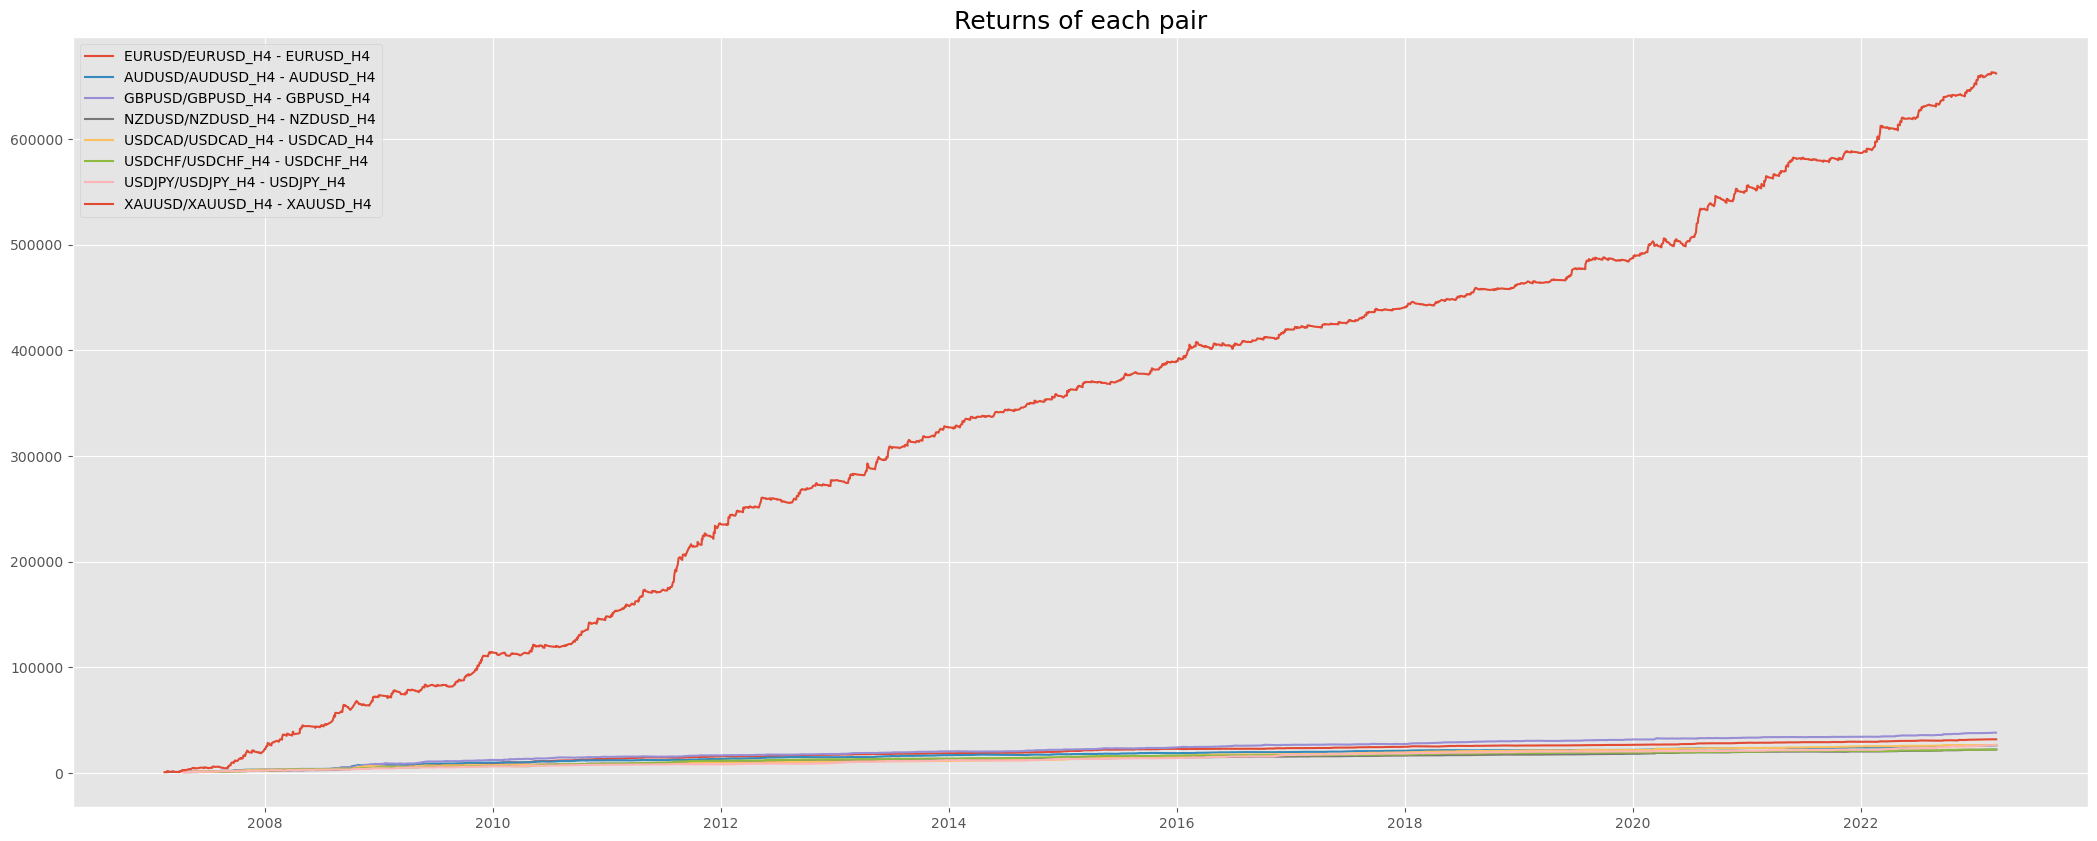

In [20]:
plt.figure(figsize = (26, 10))
for pair in range(len(pairs_list)):
    plt.plot(pairs_results[pair]['cum_res'], label = pairs_list[pair])
plt.legend()
plt.title('Returns of each pair', fontsize = 18)

***** STRATEGY PERFORMANCE *****
--------------------------------
CAGR: 384.6 %
Sharpe ratio: -0.07
Maximum drawdown 47.71 % 

Number of trades: 19182
Number of profits: 5889
Number of losses: 9480
Number of breakevens: 3813 

Winning percentage 38.32 %
ROI: 848160
--------------------------------
Average profitable trade: 248.54
Average lossing trade: -64.93
Max profitable trade: 8109.27
Max lossing trade: -1462.85


c:\Users\Win10\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:57: RuntimeWarning: overflow encountered in accumulate
  return bound(*args, **kwds)


Text(0.5, 1.0, 'return of strategy')

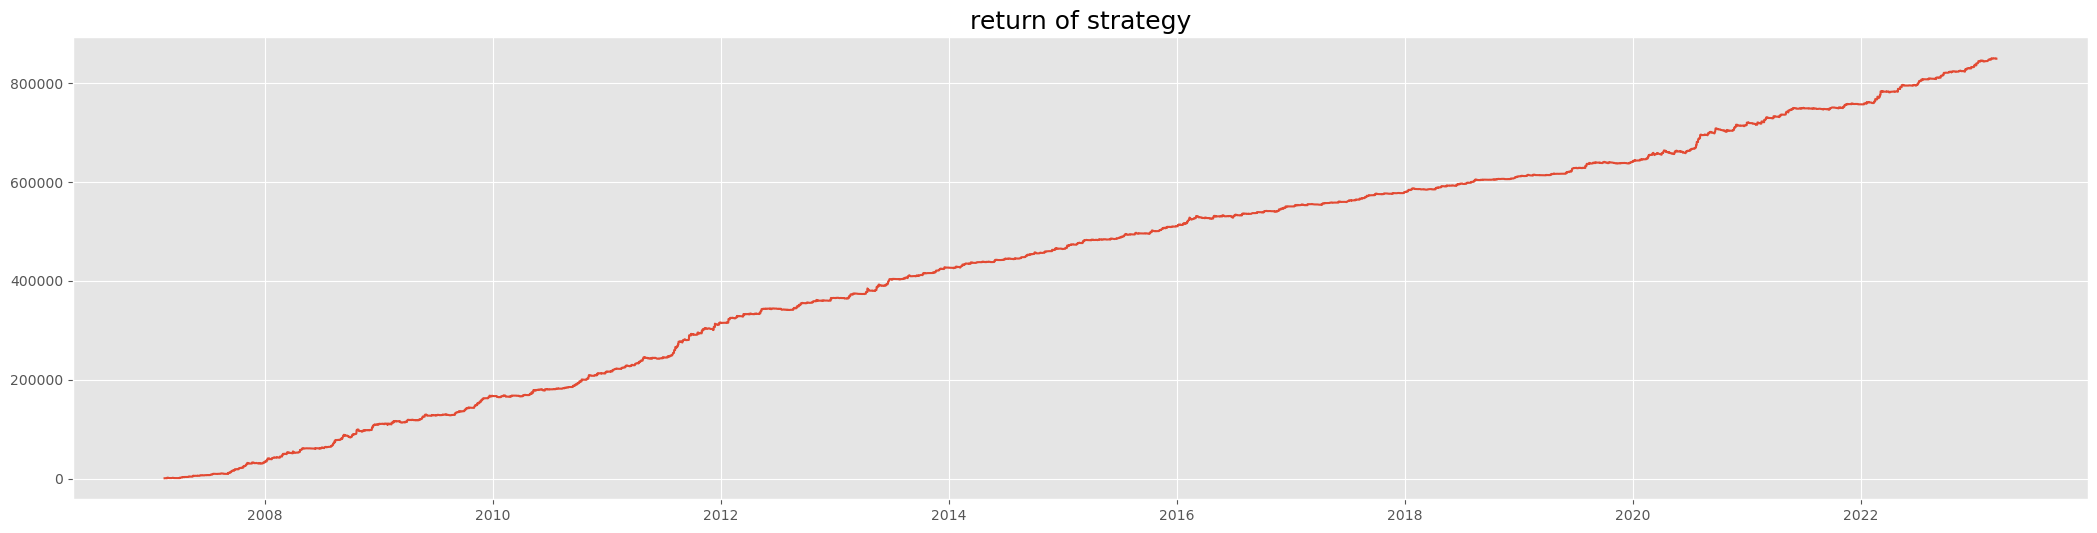

In [21]:
#Strategy performance
print('***** STRATEGY PERFORMANCE *****')
print('--------------------------------')
print('CAGR:', CAGR(strategy_results, df[0],account_size), '%')
print('Sharpe ratio:', sharpe_ratio(strategy_results))
print('Maximum drawdown', max_drawdown(strategy_results), '% \n')
print('Number of trades:', len(str_profits + str_losses + str_be))
print('Number of profits:', len(str_profits))
print('Number of losses:', len(str_losses))
print('Number of breakevens:', len(str_be), '\n')
print('Winning percentage', (round(len(str_profits) / (len(str_profits) + len(str_losses)) * 100, 2)), '%')
print('ROI:', round(strategy_results['cum_res'][-1]) - account_size)
print('--------------------------------')
print('Average profitable trade:', round(sum(str_profits) / len(str_profits), 2))
print('Average lossing trade:', round(sum(str_losses) / len(str_losses), 2))
print('Max profitable trade:', round(max(str_profits), 2))
print('Max lossing trade:', round(min(str_losses), 2))

plt.figure(figsize = (26, 6))
plt.plot(strategy_results['cum_res'])
plt.title('return of strategy', fontsize = 18)

EURUSD/EURUSD_H4 - EURUSD_H4 - PERFORMANCE
--------------------------------
Number of trades: 2375
Number of profits: 750
Number of losses: 1130
Number of breakevens: 495 

Winning percentage 39.89 %
ROI: 30945.28
--------------------------------
Average profitable trade: 75.11
Average lossing trade: -22.47
Max profitable trade: 465.9
Max lossing trade: -89.37
xxxxxxxxxxxxxxxxxxxxxxxxxxxxxx 



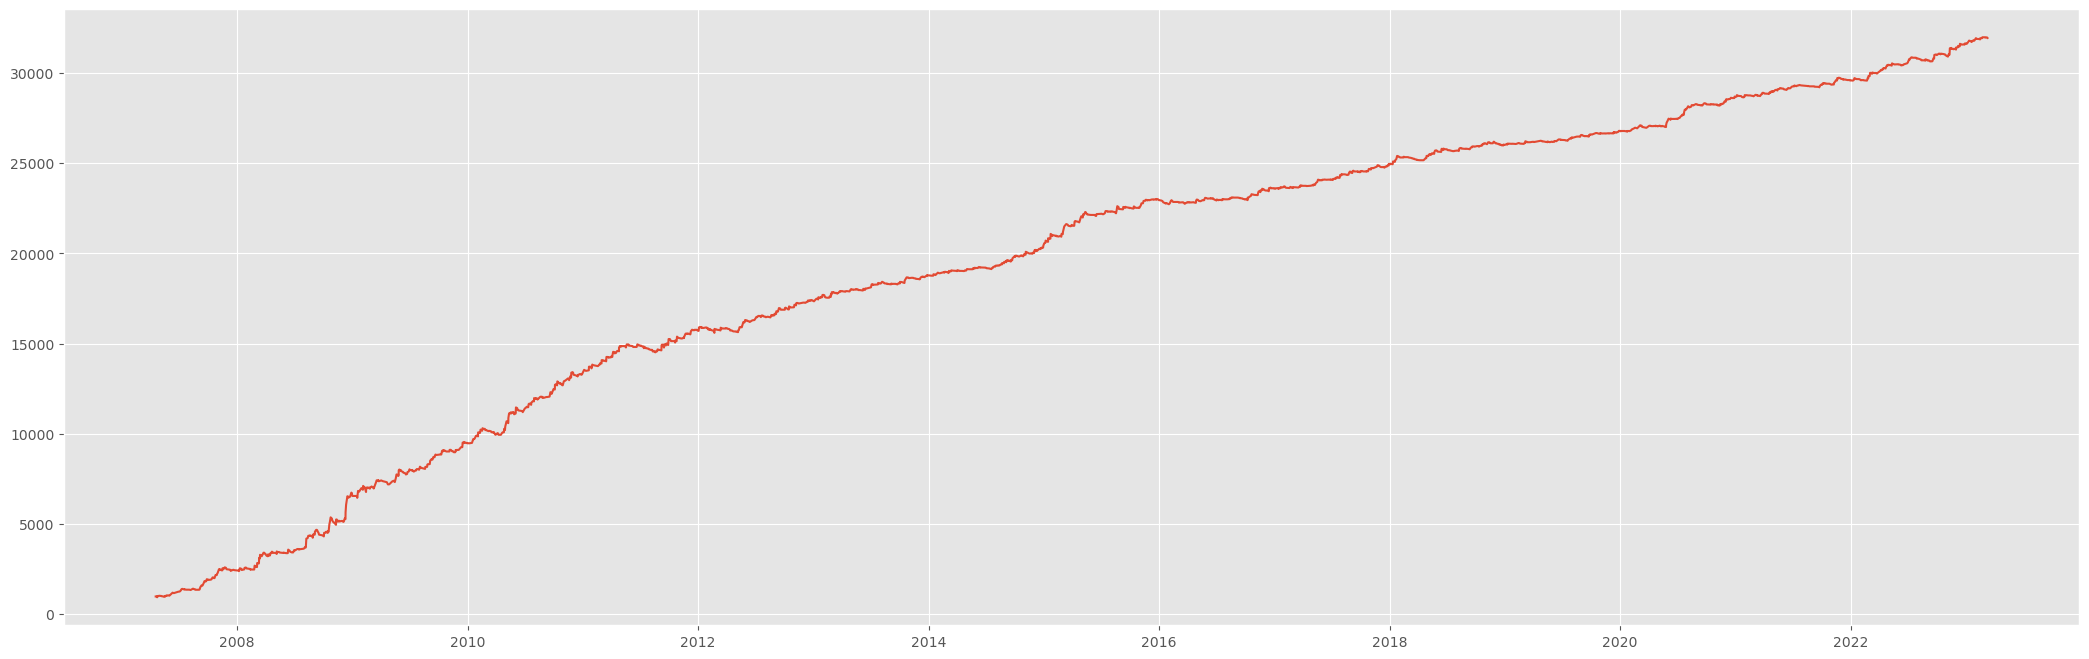

AUDUSD/AUDUSD_H4 - AUDUSD_H4 - PERFORMANCE
--------------------------------
Number of trades: 2523
Number of profits: 746
Number of losses: 1282
Number of breakevens: 495 

Winning percentage 36.79 %
ROI: 25246.78
--------------------------------
Average profitable trade: 68.13
Average lossing trade: -19.95
Max profitable trade: 546.0
Max lossing trade: -112.85
xxxxxxxxxxxxxxxxxxxxxxxxxxxxxx 



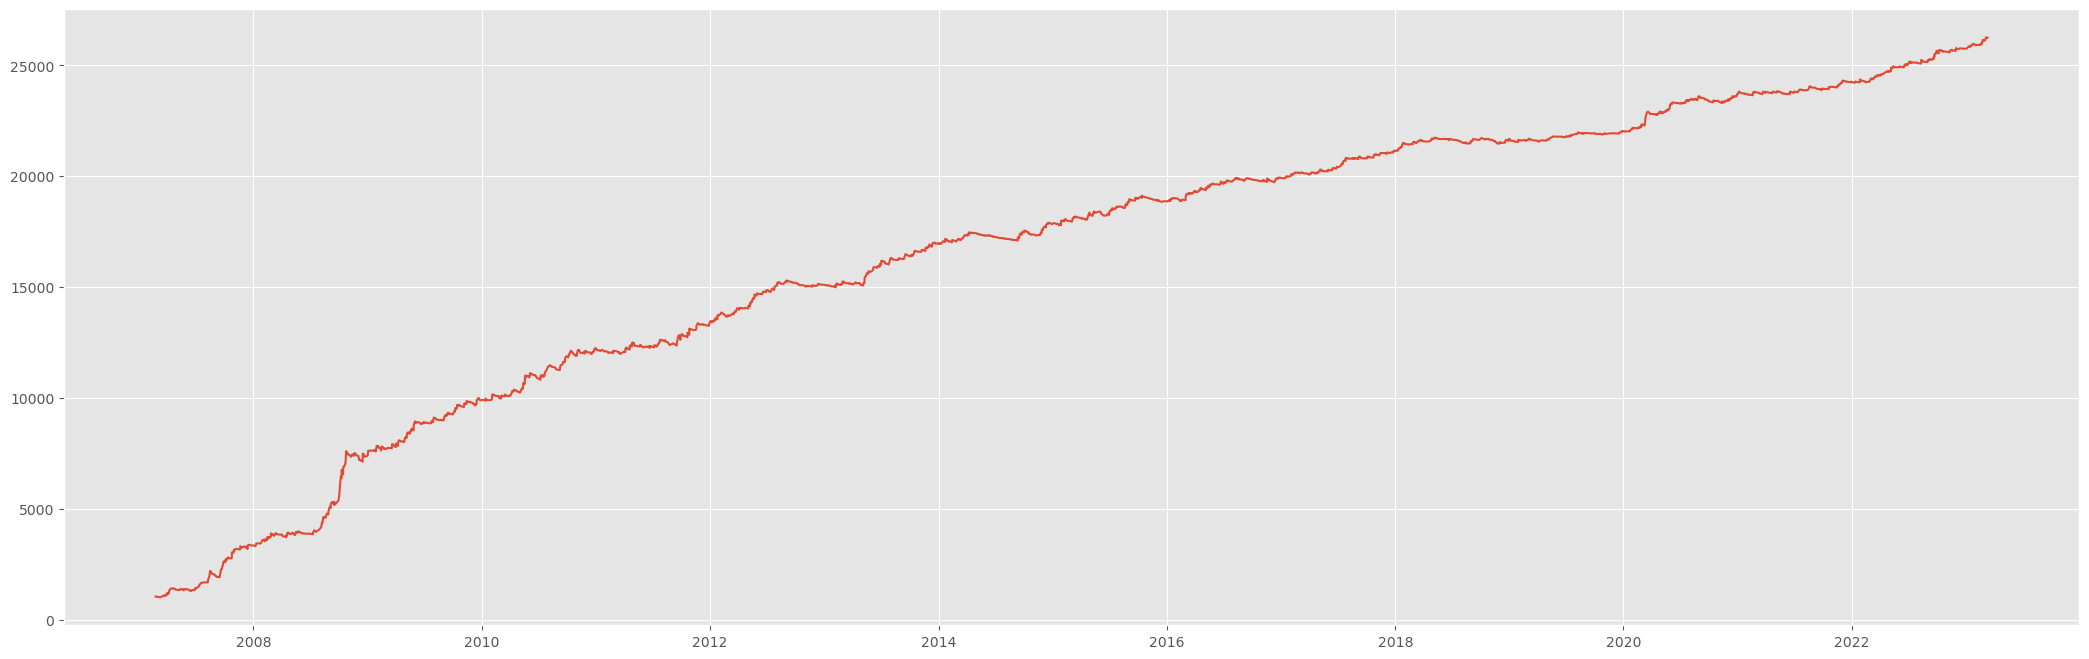

GBPUSD/GBPUSD_H4 - GBPUSD_H4 - PERFORMANCE
--------------------------------
Number of trades: 2320
Number of profits: 709
Number of losses: 1144
Number of breakevens: 467 

Winning percentage 38.26 %
ROI: 37255.53
--------------------------------
Average profitable trade: 96.09
Average lossing trade: -26.98
Max profitable trade: 750.5
Max lossing trade: -136.46
xxxxxxxxxxxxxxxxxxxxxxxxxxxxxx 



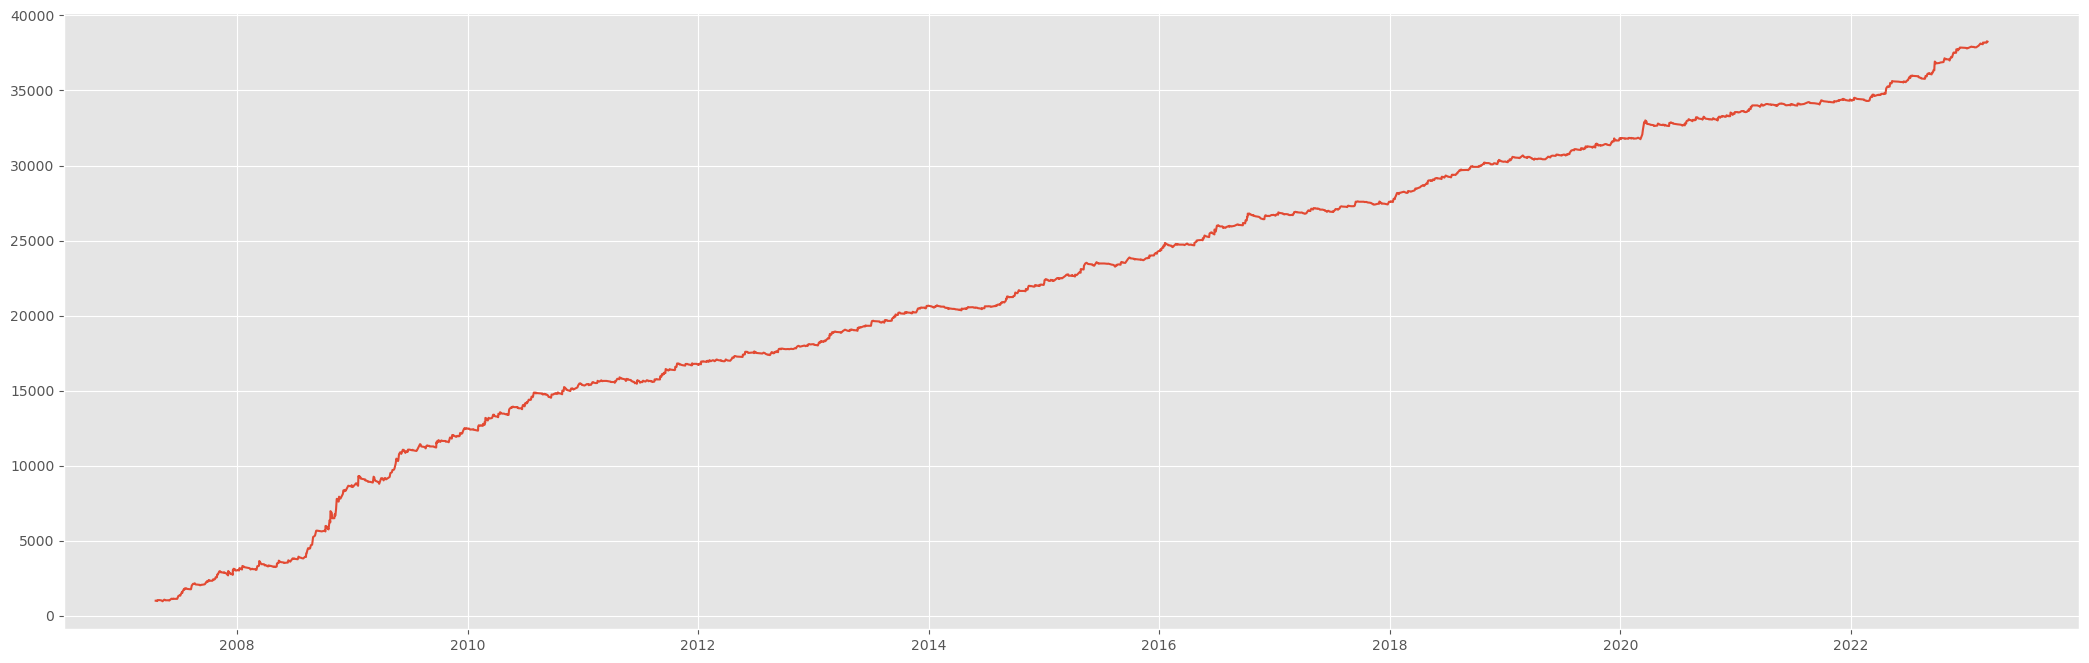

NZDUSD/NZDUSD_H4 - NZDUSD_H4 - PERFORMANCE
--------------------------------
Number of trades: 2444
Number of profits: 742
Number of losses: 1233
Number of breakevens: 469 

Winning percentage 37.57 %
ROI: 21322.74
--------------------------------
Average profitable trade: 60.12
Average lossing trade: -18.89
Max profitable trade: 481.15
Max lossing trade: -83.7
xxxxxxxxxxxxxxxxxxxxxxxxxxxxxx 



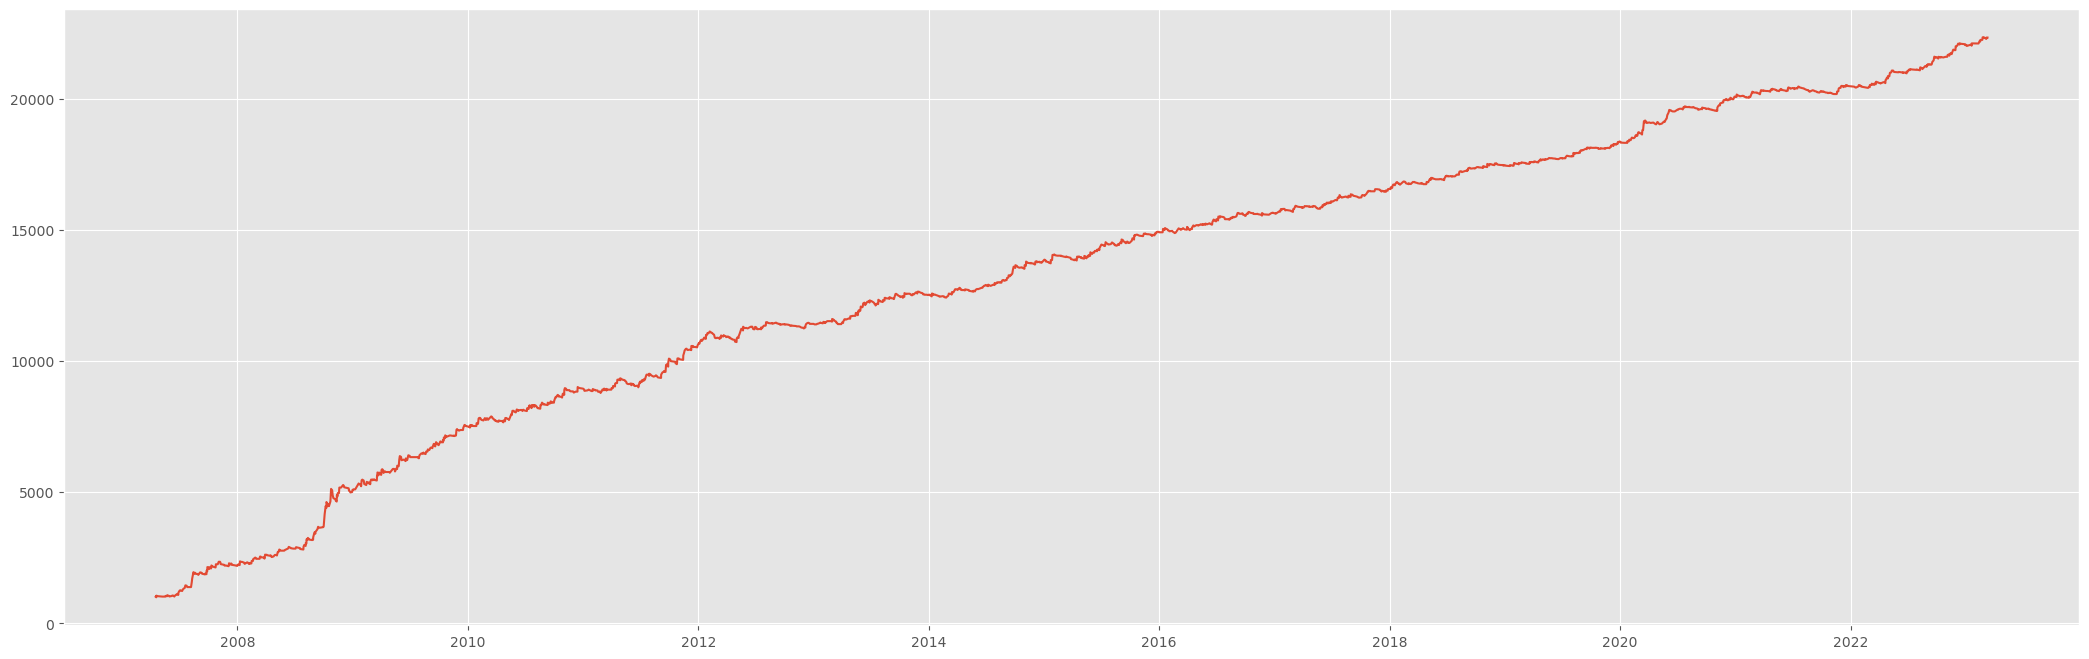

USDCAD/USDCAD_H4 - USDCAD_H4 - PERFORMANCE
--------------------------------
Number of trades: 2394
Number of profits: 726
Number of losses: 1156
Number of breakevens: 512 

Winning percentage 38.58 %
ROI: 25768.82
--------------------------------
Average profitable trade: 68.13
Average lossing trade: -20.5
Max profitable trade: 503.0
Max lossing trade: -70.78
xxxxxxxxxxxxxxxxxxxxxxxxxxxxxx 



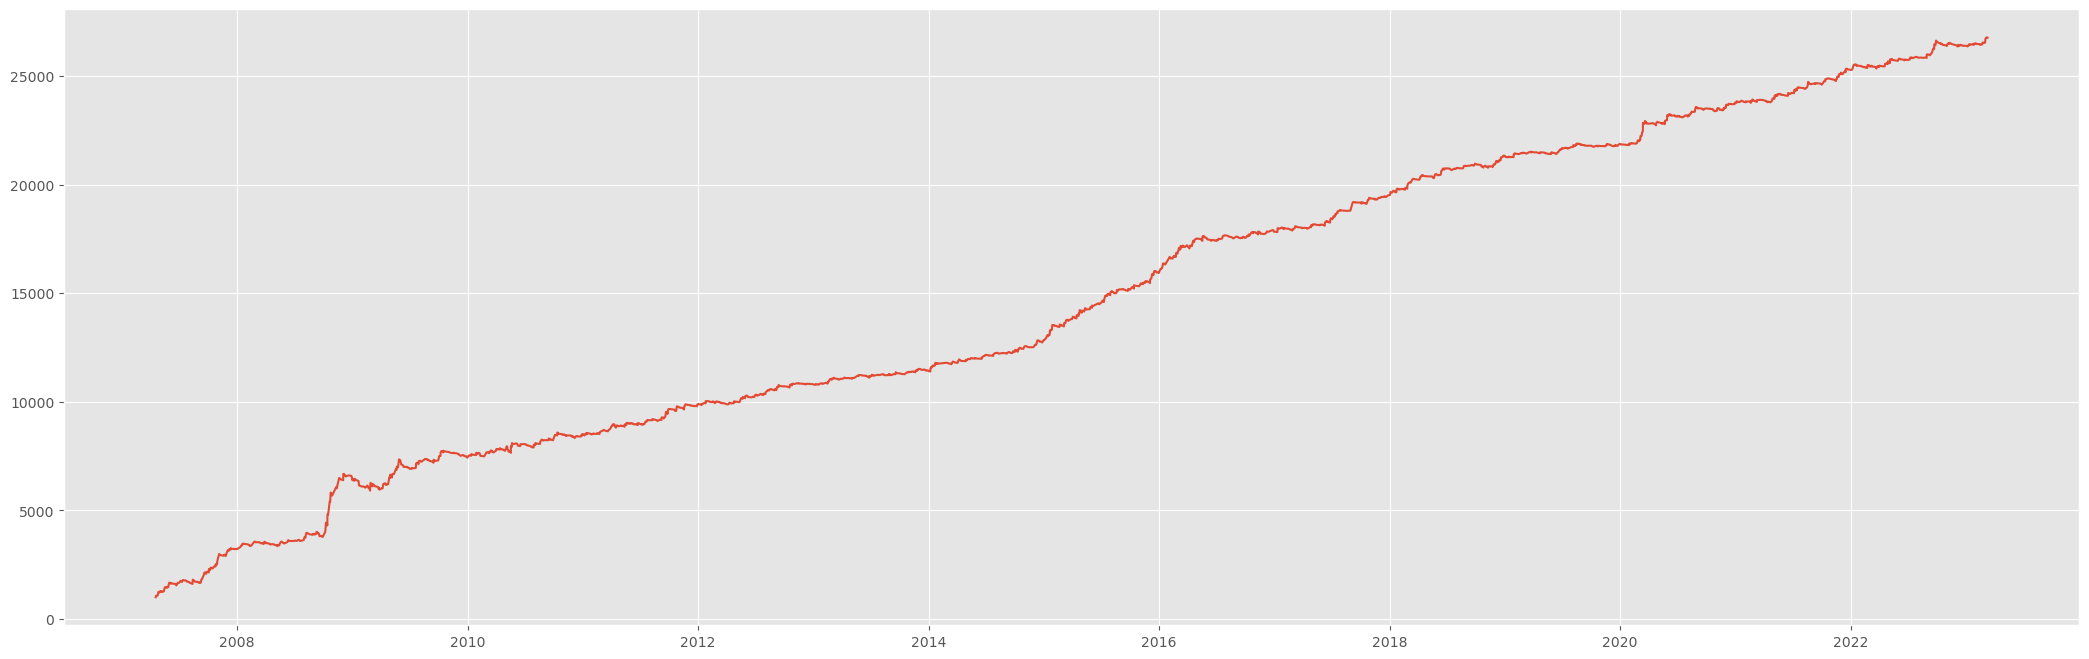

USDCHF/USDCHF_H4 - USDCHF_H4 - PERFORMANCE
--------------------------------
Number of trades: 2355
Number of profits: 715
Number of losses: 1155
Number of breakevens: 485 

Winning percentage 38.24 %
ROI: 21259.35
--------------------------------
Average profitable trade: 59.3
Average lossing trade: -18.3
Max profitable trade: 373.7
Max lossing trade: -72.82
xxxxxxxxxxxxxxxxxxxxxxxxxxxxxx 



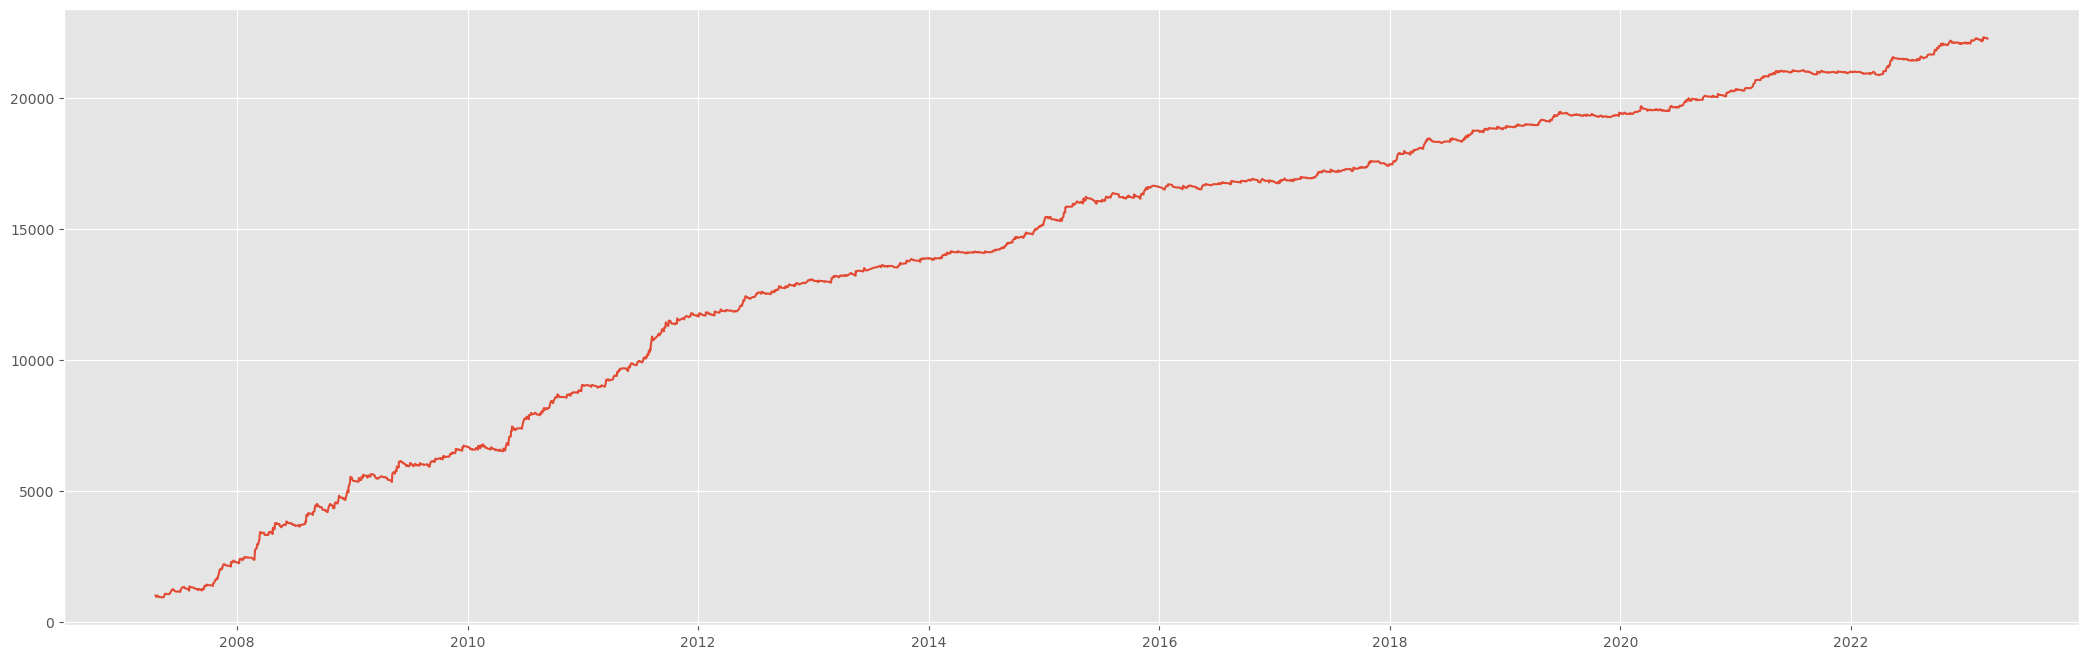

USDJPY/USDJPY_H4 - USDJPY_H4 - PERFORMANCE
--------------------------------
Number of trades: 2398
Number of profits: 741
Number of losses: 1199
Number of breakevens: 458 

Winning percentage 38.2 %
ROI: 25402.86
--------------------------------
Average profitable trade: 66.05
Average lossing trade: -19.63
Max profitable trade: 349.6
Max lossing trade: -91.7
xxxxxxxxxxxxxxxxxxxxxxxxxxxxxx 



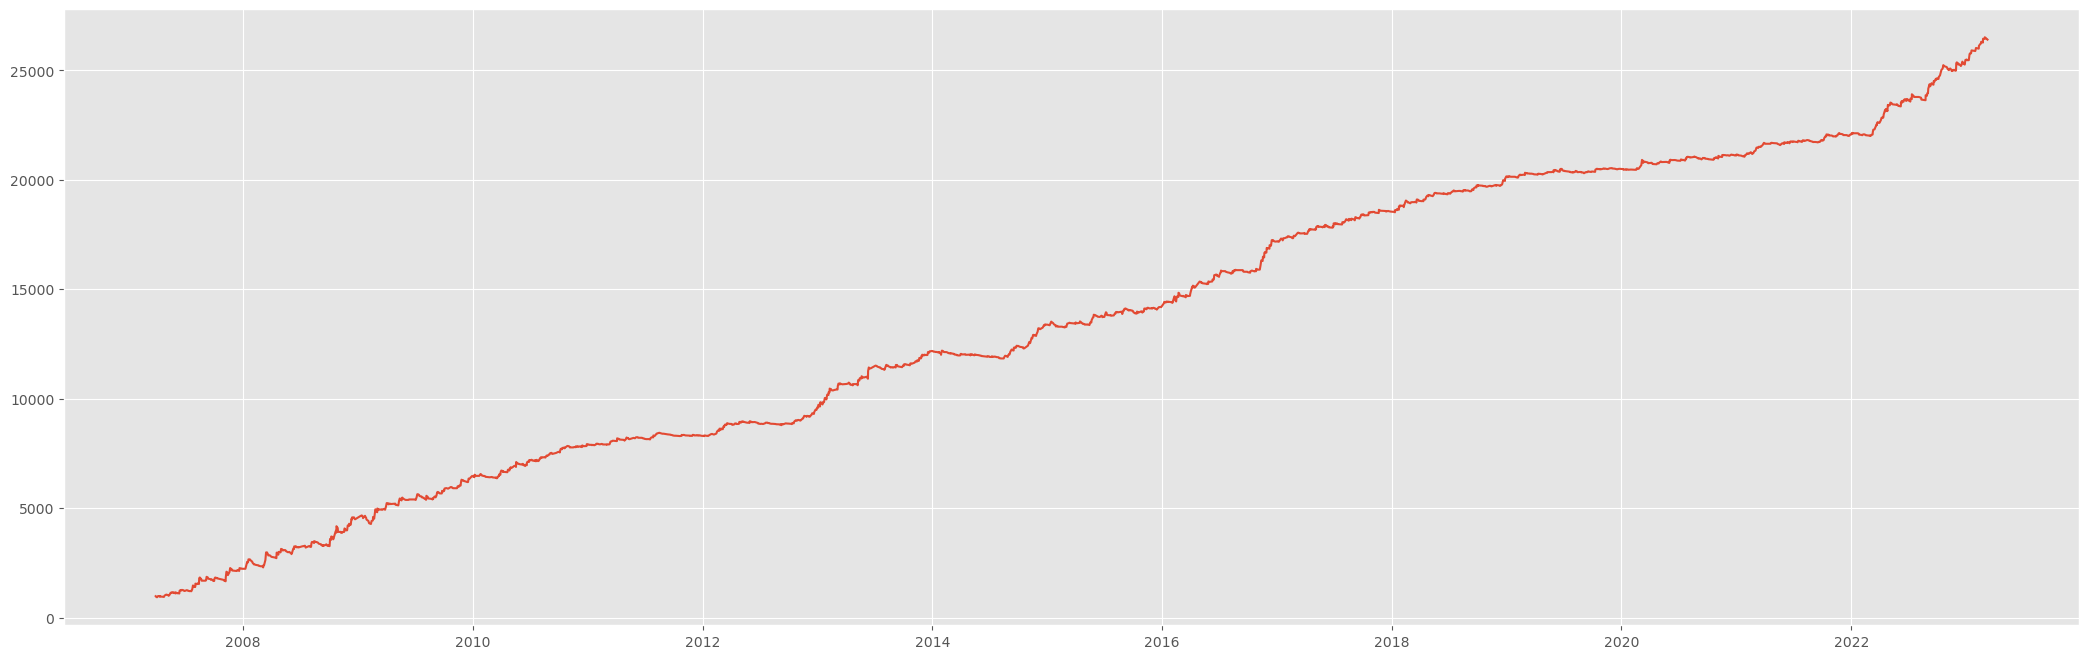

XAUUSD/XAUUSD_H4 - XAUUSD_H4 - PERFORMANCE
--------------------------------
Number of trades: 2373
Number of profits: 760
Number of losses: 1181
Number of breakevens: 432 

Winning percentage 39.16 %
ROI: 660958.63
--------------------------------
Average profitable trade: 1451.29
Average lossing trade: -374.28
Max profitable trade: 8109.27
Max lossing trade: -1462.85
xxxxxxxxxxxxxxxxxxxxxxxxxxxxxx 



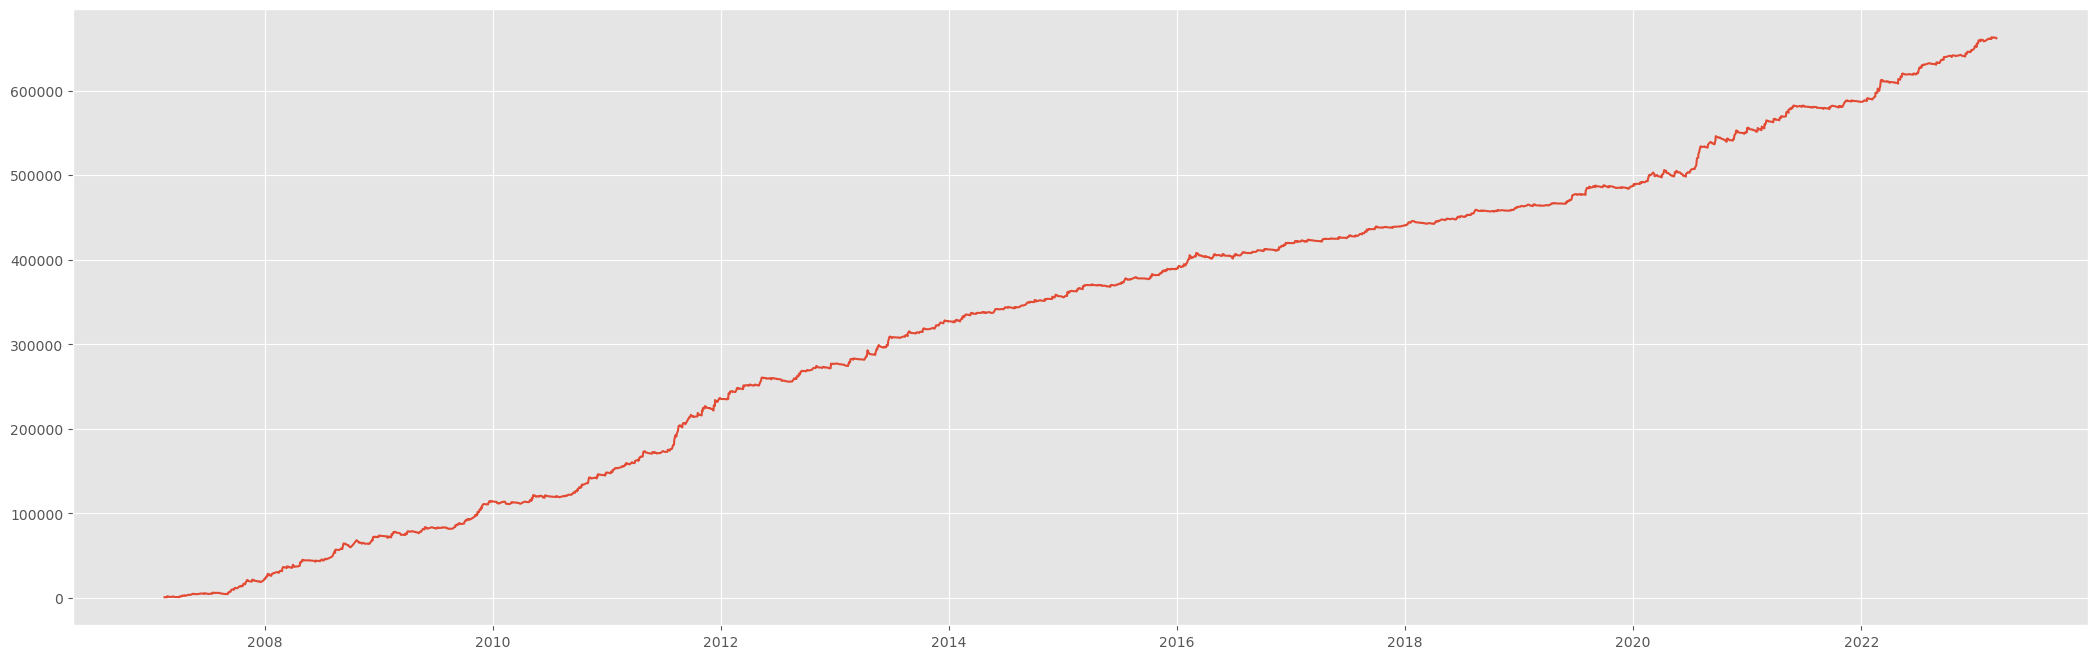

In [22]:
#performance for each pair
for pair in range(len(pairs_list)):
    print(pairs_list[pair], '- PERFORMANCE')
    print('--------------------------------')
    print('Number of trades:', len(profits[pair] + losses[pair] + be[pair]))
    print('Number of profits:', len(profits[pair]))
    print('Number of losses:', len(losses[pair]))
    print('Number of breakevens:', len(be[pair]), '\n')
    print('Winning percentage', (round(len(profits[pair]) / (len(profits[pair]) + len(losses[pair])) * 100, 2)), '%')
    print('ROI:', round(pairs_results[pair]['cum_res'][-1] - account_size, 2))
    print('--------------------------------')
    print('Average profitable trade:', round(sum(profits[pair]) / len(profits[pair]), 2))
    print('Average lossing trade:', round(sum(losses[pair]) / len(losses[pair]), 2))
    print('Max profitable trade:', round(max(profits[pair]), 2))
    print('Max lossing trade:', round(min(losses[pair]), 2))
    print('xxxxxxxxxxxxxxxxxxxxxxxxxxxxxx \n')
    
    plt.figure(figsize = (26, 8))
    plt.plot(pairs_results[pair]['cum_res'])
    plt.show()